In [2]:
## EDIT:
base_dir = '/glade/work/kjmayer/research/catalyst/TransferLearning/runmean_analysis/artificial_bias/perfectmodel_TLtest/E3SM_analysis/'

In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import random
import pandas as pd
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow import keras
from tensorflow.keras import layers
import time

import sys
sys.path.append(base_dir+'functions/')
from utils import split_SDbias, split_retrain
from exp_hp import get_hp

2024-08-06 12:14:23.987971: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  0


### Load standardized E3SM

In [32]:
EXP_NAME = 'exp2'
hps = get_hp(EXP_NAME)

In [27]:
print('Validation Member: '+str(hps['val_mems'][0]))
_, ann1X1val, _, _, ann1Y1val, _, inew = split_SDbias(trainmems = hps['train_mems'],
                                                  valmem = hps['val_mems'][0],
                                                  testmem = hps['test_mems'][0],
                                                  months = [11,12,1,2], # months for X (Y+leadtime are accounted for in function)
                                                  lead = hps['LEAD'])

ann1X1val = ann1X1val.reshape((ann1X1val.shape[0],ann1X1val.shape[1]*ann1X1val.shape[2]))

GLOBAL_SEED = hps['GLOBAL_SEED']
np.random.seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)
tf.random.set_seed(GLOBAL_SEED)

Validation Member: 0191
files do not exist - loading data & saving


In [33]:
EXP_NAME2 = 'exp2_retrain'
hps2 = get_hp(EXP_NAME2)

In [24]:
%%time
print('Validation Member: '+str(hps2['val_mems'][0]))

_, ann2X1val, _, _, ann2Y1val, _,_ = split_retrain(trainmems = hps2['train_mems'],
                                                  valmem = hps2['val_mems'][0],
                                                  testmem = hps2['test_mems'][0],
                                                  months = [11,12,1,2], # months for X (Y+leadtime are accounted for in function)
                                                  lead = hps2['LEAD'])

ann2X1val = ann2X1val.reshape((ann2X1val.shape[0],ann2X1val.shape[1]*ann2X1val.shape[2]))

#----- SET UP & TRAIN NN -----
GLOBAL_SEED = hps['GLOBAL_SEED']
np.random.seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)
tf.random.set_seed(GLOBAL_SEED)

Validation Member: 0291
loading data & saving
CPU times: user 10.1 s, sys: 1.63 s, total: 11.7 s
Wall time: 13.2 s


0
235/235 [==============================] - 0s 831us/step
1
235/235 [==============================] - 0s 725us/step
2
235/235 [==============================] - 0s 731us/step
3
235/235 [==============================] - 0s 729us/step
4
235/235 [==============================] - 0s 726us/step
5
235/235 [==============================] - 0s 708us/step
6
235/235 [==============================] - 0s 726us/step
7
235/235 [==============================] - 0s 739us/step
8
235/235 [==============================] - 0s 877us/step
9
235/235 [==============================] - 0s 741us/step
0
241/241 [==============================] - 0s 734us/step
1
241/241 [==============================] - 0s 718us/step
2
241/241 [==============================] - 0s 736us/step
3
241/241 [==============================] - 0s 734us/step
4
241/241 [==============================] - 0s 726us/step
5
241/241 [==============================] - 0s 725us/step
6
241/241 [==============================] - 0s 1ms/step

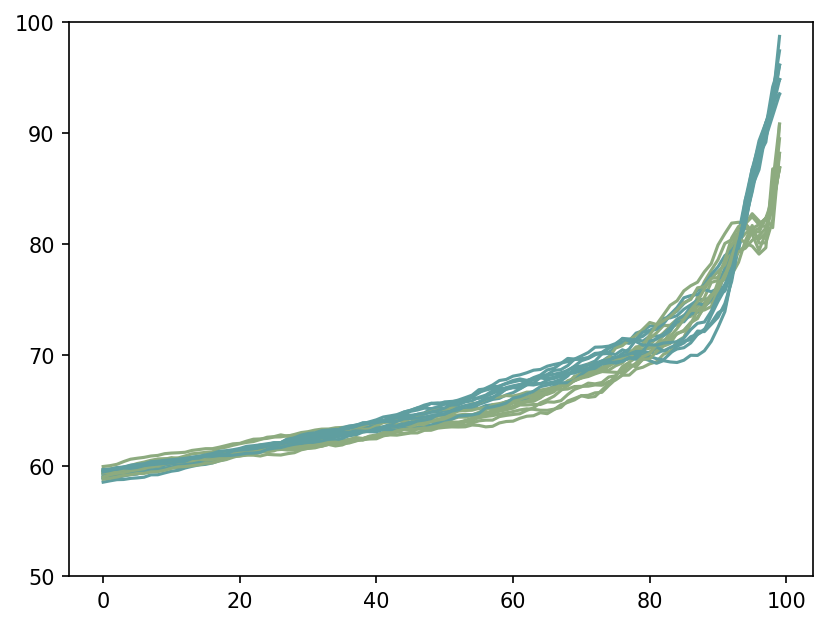

In [34]:
## ---- original ----
ann1_acc_all = []
for SEED in range(10):
    print(SEED)
    annfi_name = 'ann_60Eshift_'+EXP_NAME+'_seed'+str(SEED)+'.h5'
    ann = tf.keras.models.load_model(base_dir+'train/saved_models/'+annfi_name)

    pred = ann.predict(ann1X1val)
    acc = []
    predconf = np.max(pred,axis=-1)
    predval  = np.argmax(pred,axis=-1)

    for q in range(100):
        iconf = np.where(predconf >= np.percentile(predconf,q=q))
        icorr = np.where(predval[iconf] == ann1Y1test[iconf])

        acc.append((len(icorr[0])/len(iconf[0]))*100)
    ann1_acc_all.append(acc)

## ---- retrain ----
ann2_acc_all = []
for SEED in range(10):
    print(SEED)
    annfi_name = 'ann2_60Eshift_'+EXP_NAME2+'.8_ann1-'+EXP_NAME+'_seed'+str(SEED)+'.h5'
    ann = tf.keras.models.load_model(base_dir+'train/saved_models/'+annfi_name)

    pred = ann.predict(ann2X1val)
    acc = []
    predconf = np.max(pred,axis=-1)
    predval  = np.argmax(pred,axis=-1)

    for q in range(100):
        iconf = np.where(predconf >= np.percentile(predconf,q=q))
        icorr = np.where(predval[iconf] == ann2Y1val[iconf])

        acc.append((len(icorr[0])/len(iconf[0]))*100)
    ann2_acc_all.append(acc)


## ---- plot ----
preTLcolor = (141/255,171/255,127/255,1.)
postTLcolor = 'cadetblue'
for i in range(10):
    plt.plot(ann1_acc_all[i],color=preTLcolor)
    plt.plot(ann2_acc_all[i],color=postTLcolor)
    plt.ylim(50,100)
plt.show()